In [1]:
import os
from collections import OrderedDict
import logging

import numpy as np
from astropy.table import Table

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.DEBUG)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.DEBUG)


In [2]:
# Load the data
data = np.load("../data/test1/images.npy")
mask = np.load("../data/test1/mask.npy")
variance = np.load("../data/test1/variance.npy")
psfs = np.load("../data/test1/psfs.npy")
simTable= Table.read("../data/test1/sim.fits")
all_peaks = np.load("../data/test1/peaks.npy")
bboxes = np.load("../data/test1/bboxes.npy")

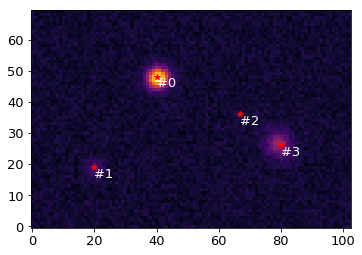

In [10]:
#parents = [len(peaks)>1 for peaks in all_peaks]
parents = [len(peaks)==4 for peaks in all_peaks]
bbox = bboxes[parents][0]
peaks = np.array(list(all_peaks[parents][0]))
# get the peak positions in image coordinates
img_peaks = np.zeros_like(peaks)
img_peaks[:,0] = peaks[:,0]-bbox[2]
img_peaks[:,1] = peaks[:,1]-bbox[0]
img = data[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
weights = variance[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
plt.imshow(img[0])
plt.plot(img_peaks[:,0], img_peaks[:,1], 'r*')
for i in range(len(peaks)):
    plt.text(img_peaks[i,0], img_peaks[i,1], '#%d' %i, va='top', ha='left', color='w')

In [33]:
result = deblender.nmf.deblend(img, peaks=img_peaks, constraints=["mS", "mS", "mS", "mS"], weights=weights, 
                               psf=None, max_iter=1000, e_rel=[1e-6,1e-3], psf_thresh=3e-3, l0_thresh=5e-4,
                               traceback=False, monotonicUseNearest=True)
A, S, model, P_, Tx, Ty, tr = result

DEBUG:deblender.nmf:Shape: (70, 103)
DEBUG:deblender.nmf:proxs_g: [None, [<function prox_zero at 0x1061132a8>, <functools.partial object at 0x1181cf578>]]
DEBUG:deblender.nmf:steps_g: None
DEBUG:deblender.nmf:steps_g_update: steps_f
DEBUG:deblender.nmf:Ls: [[None], [<proxmin.utils.MatrixAdapter object at 0x1177ca190>, None]]
INFO:proxmin.algorithms:Completed 1001 iterations


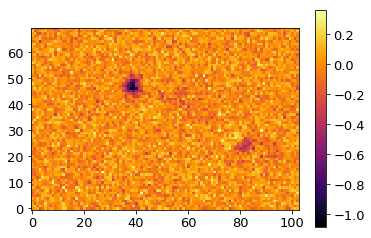

In [31]:
plt.imshow(img[0]-model[0])
plt.colorbar()
plt.show()

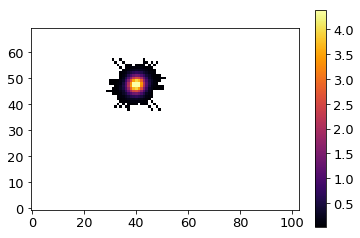

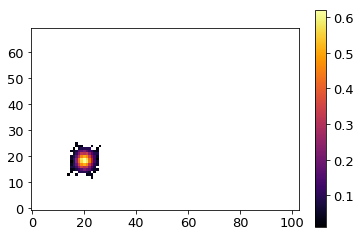

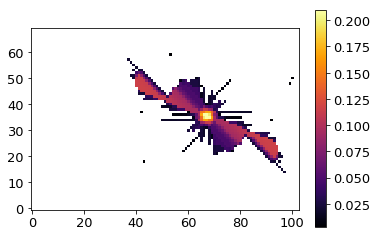

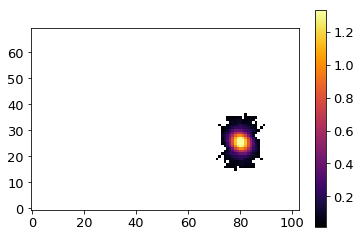

In [32]:
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A[:,k], S[k].flatten(), Tx[k], Ty[k], shape=(S[k].shape))[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()

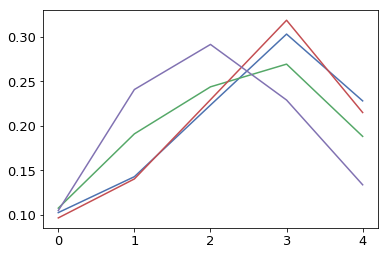

In [20]:
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()